air_daily基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6573 entries, 0 to 6572
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          6573 non-null   object 
 1   station_id    6573 non-null   object 
 2   station_name  6573 non-null   object 
 3   area_type     6573 non-null   object 
 4   PM2_5         6573 non-null   float64
 5   PM10          6573 non-null   float64
 6   NO2           6573 non-null   float64
 7   O3            6573 non-null   float64
 8   AQI           6573 non-null   int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 462.3+ KB
air_daily前几行内容信息：
	date	station_id	station_name	area_type	PM2_5	PM10	NO2	O3	AQI
0	2018-01-01	Tianhe	天河站	商业区	37.6	66.7	12.0	35.0	104
1	2018-01-01	Yuexiu	越秀站	居民区	42.2	88.9	12.0	35.0	110
2	2018-01-01	Baiyun	白云站	工业区	47.3	82.9	12.0	35.0	118
3	2018-01-02	Tianhe	天河站	商业区	43.3	84.6	12.0	35.0	112
4	2018-01-02	Yuexiu	越秀站	居民区	35.8	68.3	12.0	35.0	101

i

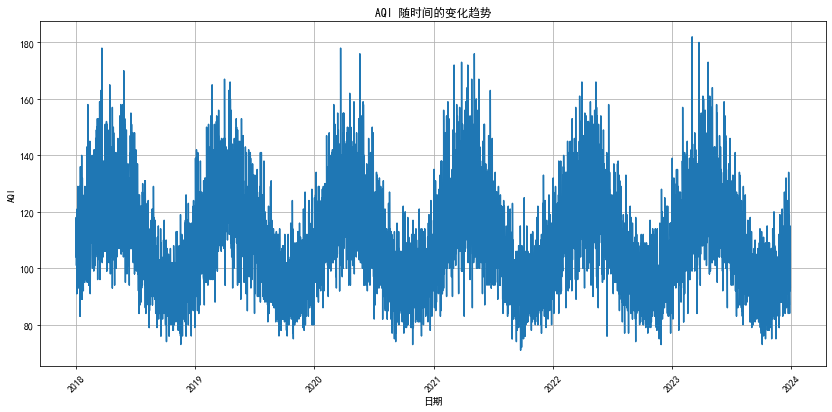

C:\Users\北莫\AppData\Roaming\Python\Python312\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\北莫\AppData\Local\Temp\ipykernel_17464\1175515739.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('aqi_meteo_correlation.png')
C:\Users\北莫\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


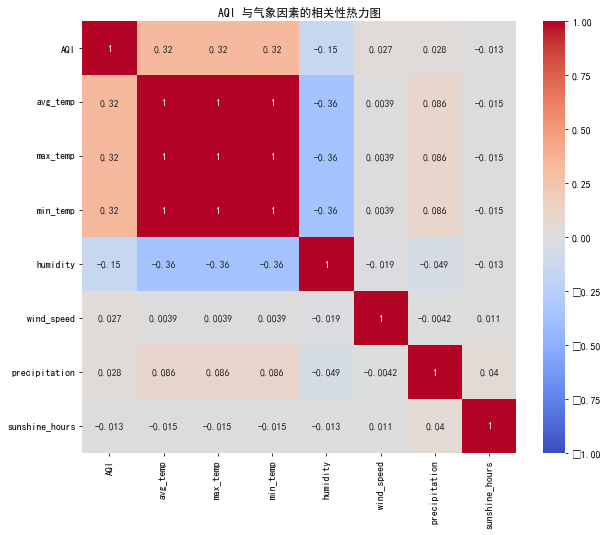

均方误差 (MSE): 0.03048707224334599
R^2 值: 0.9999028385992504


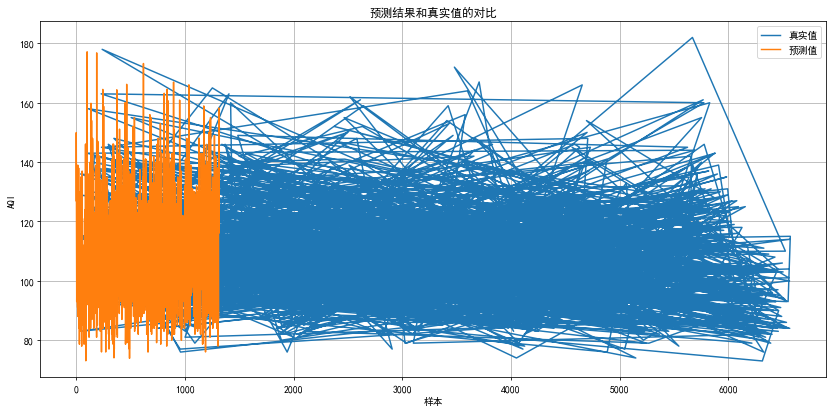

In [7]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, PageBreak, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 加载数据集
air_daily = pd.read_csv('guangzhou_air_daily.csv')
industry_monthly = pd.read_csv('guangzhou_industry_monthly.csv')
meteo_daily = pd.read_csv('guangzhou_meteo_daily.csv')
time_features = pd.read_csv('guangzhou_time_features.csv')
traffic_daily = pd.read_csv('guangzhou_traffic_daily.csv')

# 查看各个数据集的基本信息
print('air_daily基本信息：')
air_daily.info()

# 查看数据集行数和列数
rows, columns = air_daily.shape

print('air_daily前几行内容信息：')
print(air_daily.head().to_csv(sep='\t', na_rep='nan'))

print('industry_monthly基本信息：')
industry_monthly.info()

rows, columns = industry_monthly.shape

# 长表数据查看数据前几行信息
print('industry_monthly前几行内容信息：')
print(industry_monthly.head().to_csv(sep='\t', na_rep='nan'))

print('meteo_daily基本信息：')
meteo_daily.info()

rows, columns = meteo_daily.shape

print('meteo_daily前几行内容信息：')
print(meteo_daily.head().to_csv(sep='\t', na_rep='nan'))

print('time_features基本信息：')
time_features.info()

rows, columns = time_features.shape

 # 长表数据查看数据前几行信息
print('time_features前几行内容信息：')
print(time_features.head().to_csv(sep='\t', na_rep='nan'))

print('traffic_daily基本信息：')
traffic_daily.info()

rows, columns = traffic_daily.shape

print('traffic_daily前几行内容信息：')
print(traffic_daily.head().to_csv(sep='\t', na_rep='nan'))

# 合并数据
merged_data = pd.merge(air_daily, meteo_daily, on='date', how='inner')
merged_data = pd.merge(merged_data, time_features, on='date', how='inner')
merged_data = pd.merge(merged_data, traffic_daily, on='date', how='inner')

# 转换日期格式
merged_data['date'] = pd.to_datetime(merged_data['date'])

# 设置图片清晰度
plt.rcParams['figure.dpi'] = 70

# 绘制 AQI 随时间的变化趋势图
plt.figure(figsize=(12, 6))
plt.plot(merged_data['date'], merged_data['AQI'])
plt.title('AQI 随时间的变化趋势')
plt.xlabel('日期')
plt.xticks(rotation=45)
plt.ylabel('AQI')
plt.grid(True)
plt.tight_layout()
plt.savefig('aqi_trend.png')
plt.show()

# 计算 AQI 与气象因素的相关性
correlation = merged_data[['AQI', 'avg_temp','max_temp','min_temp', 'humidity', 'wind_speed', 'precipitation','sunshine_hours']].corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('AQI 与气象因素的相关性热力图')
plt.savefig('aqi_meteo_correlation.png')
plt.show()
# 构建预测模型
# 选择特征和目标变量
features = merged_data[['PM2_5', 'PM10', 'NO2', 'O3', 'avg_temp','max_temp','min_temp', 'humidity', 'wind_speed', 'precipitation','sunshine_hours', 'year','month', 'day', 'day_of_week', 'is_weekend', 'is_holiday','season', 'traffic_volume', 'congestion_index', 'accidents']]
target = merged_data['AQI']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 构建随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('均方误差 (MSE):', mse)
print('R^2 值:', r2)
# 绘制预测结果和真实值的对比图

model_building_text = '在构建预测模型时，我们选择特征和目标变量。然后，我们划分训练集和测试集。使用随机森林回归模型进行训练，并在测试集上进行预测。最后，我们评估模型性能，并绘制预测结果和真实值的对比图。'
#绘制预测结果和真实值的对比图
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='真实值')
plt.plot(y_pred, label='预测值')
plt.title('预测结果和真实值的对比')
plt.xlabel('样本')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('prediction_comparison.png')
plt.show()

C:\Users\北莫\AppData\Roaming\Python\Python312\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\北莫\AppData\Local\Temp\ipykernel_17464\920593021.py:43: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('images/aqi_meteo_correlation.png')


均方误差 (MSE): 0.03
决定系数 (R²): 1.00


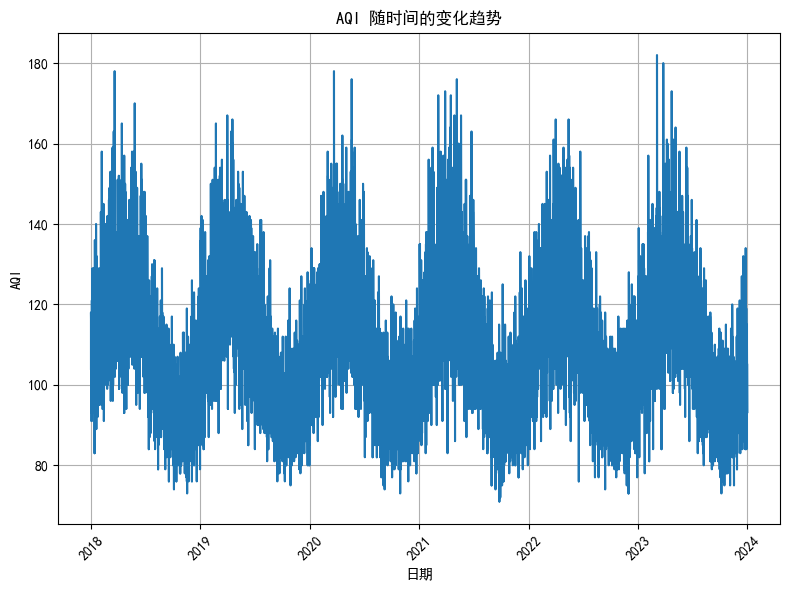

C:\Users\北莫\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


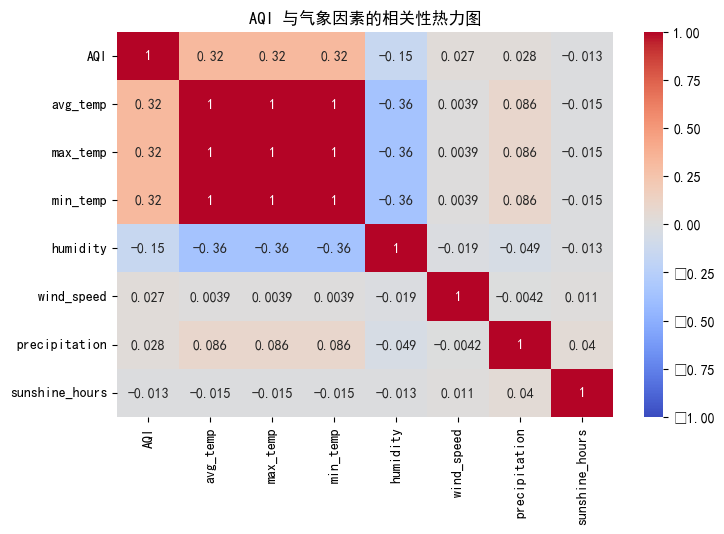

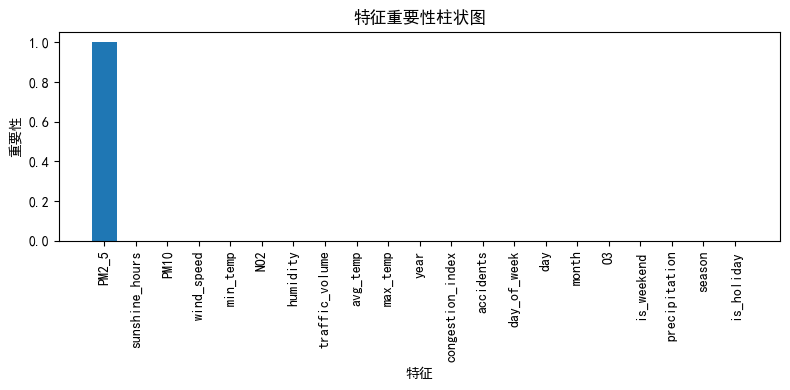

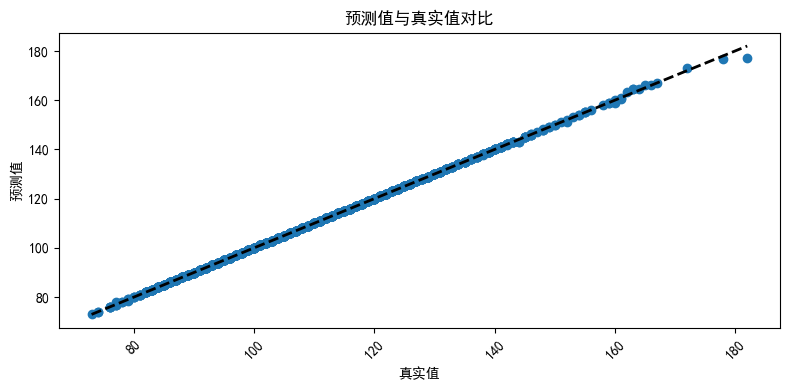

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import pandas as pd
# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
# 确保保存图片的目录存在
os.makedirs('images', exist_ok=True)

# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100

# 重新合并数据
merged_data = pd.merge(air_daily, meteo_daily, on='date', how='inner')
merged_data = pd.merge(merged_data, time_features, on='date', how='inner')
merged_data = pd.merge(merged_data, traffic_daily, on='date', how='inner')

# 转换日期格式
merged_data['date'] = pd.to_datetime(merged_data['date'])

# 绘制 AQI 随时间的变化趋势图
plt.figure(figsize=(8, 6))
plt.plot(merged_data['date'], merged_data['AQI'])
plt.title('AQI 随时间的变化趋势')
plt.xlabel('日期')
plt.xticks(rotation=45)
plt.ylabel('AQI')
plt.grid(True)
plt.tight_layout()
plt.savefig('images/aqi_trend.png')

# 计算 AQI 与气象因素的相关性
correlation = merged_data[['AQI', 'avg_temp', 'max_temp', 'min_temp', 'humidity', 'wind_speed', 'precipitation', 'sunshine_hours']].corr()

# 绘制热力图
plt.figure(figsize=(8, 5))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('AQI 与气象因素的相关性热力图')
plt.savefig('images/aqi_meteo_correlation.png')

# 构建预测模型
# 选择特征和目标变量
features = merged_data[['PM2_5', 'PM10', 'NO2', 'O3', 'avg_temp', 'max_temp', 'min_temp', 'humidity', 'wind_speed', 'precipitation', 'sunshine_hours', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'is_holiday', 'season', 'traffic_volume', 'congestion_index', 'accidents']]
target = merged_data['AQI']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 构建随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'均方误差 (MSE): {mse:.2f}')
print(f'决定系数 (R²): {r2:.2f}')

# 绘制特征重要性柱状图
importances = model.feature_importances_
feature_names = features.columns

# 获取特征重要性得分并排序
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.bar(range(len(feature_names)), importances[indices])
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
plt.title('特征重要性柱状图')
plt.xlabel('特征')
plt.ylabel('重要性')
plt.tight_layout()
plt.savefig('images/feature_importance.png')

# 绘制预测值与真实值对比图
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('真实值')
plt.xticks(rotation=45)
plt.ylabel('预测值')
plt.title('预测值与真实值对比')
plt.tight_layout()
plt.savefig('images/prediction_vs_actual.png')

# 显示图片
plt.show()